In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [110]:
## load Cleaned Data
cleaned_data = pd.read_csv("cleaned_data.csv", index_col="GEOID")
cleaned_data.index = cleaned_data.index.astype(int)

## load MCDA Data
mcda_output = pd.read_csv("mcda_output.csv", index_col="GEOID")
mcda_output.index = mcda_output.index.astype(int)

#load Adoption Data
predicted_generation_data = pd.read_csv("predicted_adoption_generation_data.csv")
#print(predicted_generation_data.head)

/var/folders/67/r87g720s2653g554zdhtz1vh0000gn/T/ipykernel_20956/2742587371.py:2: DtypeWarning: Columns (181) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv("cleaned_data.csv", index_col="GEOID")


In [96]:
#Calculate avoided emissions and air pollution

#From EPA 2022 AVERT Emission Rates (lb/KWh) for Distributed PV
nat_avg_emission_rates = {
    'co2': 1.451,
    'pm25': 0.00009  
}
nat_distpv_cap_factor = 0.2526
hours_per_year = 8760
mt = 0.000453592 #conversion from lbs to metric tonnes

#calculate for total 2023 Cap 1.8GW
total_avoided_gen = 1.8 * 1000000 * hours_per_year * nat_distpv_cap_factor
total_co2_avoided = total_avoided_gen * nat_avg_emission_rates['co2'] * mt
total_pm25_avoided = total_avoided_gen * nat_avg_emission_rates['pm25'] * mt
print(total_co2_avoided)
print(total_pm25_avoided)

#Calculate per tract
benefits_data=predicted_generation_data.copy()
benefits_data['pm25_avoided'] = benefits_data['yearly_kwh']*nat_avg_emission_rates['pm25'] * mt
benefits_data['co2_avoided'] = benefits_data['yearly_kwh']*nat_avg_emission_rates['co2'] * mt

print(benefits_data['pm25_avoided'].describe())
print(benefits_data['co2_avoided'].describe())


2621457.1080176258
162.598993605504
count    768859.000000
mean          0.009482
std           0.013714
min           0.000000
25%           0.003394
50%           0.005911
75%           0.010861
max           1.017352
Name: pm25_avoided, dtype: float64
count    768859.000000
mean        152.868830
std         221.106821
min           0.000000
25%          54.723656
50%          95.301274
75%         175.097730
max       16401.972509
Name: co2_avoided, dtype: float64


In [284]:
benefits_2023 = benefits_data[(benefits_data['year'] == 2023) & (benefits_data['scenario'] == 'med')] 
merged_mcda_benefits = benefits_2023.merge(mcda_output[['impact_score', 'feasibility_score', 'total_score']], left_on="GEOID", right_index=True)
# print(merged_mcda_benefits)
print(benefits_data['co2_avoided'].describe())
print(benefits_data['pm25_avoided'].describe())

        Unnamed: 0   index        GEOID    year  yearly_sunlight_kwh_median   
3             1374  296213   1073000100  2023.0                12558.860400  \
38            1411  296225   1073000300  2023.0                12465.138770   
73            1448  296237   1073000400  2023.0                 9668.748651   
108           1485  296249   1073000500  2023.0                 9967.803699   
143           1522  296261   1073000700  2023.0                11486.199210   
...            ...     ...          ...     ...                         ...   
768687      813100  554465  56025000400  2023.0                11126.356400   
768722      813137  554477  56025000501  2023.0                17064.065840   
768757      813174  554489  56025000502  2023.0                15829.814790   
768792      813211  554501  56025000800  2023.0                 9054.949146   
768827      813248  554513  56025000901  2023.0                13753.511740   

        kw_median       county_name state_abbr  ado

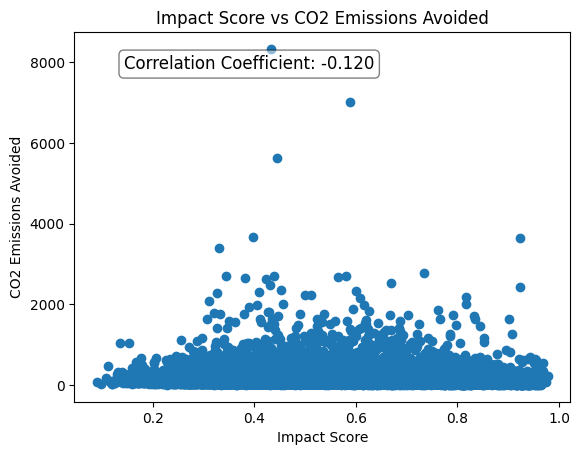

In [114]:
#Compare impact score with projected emissions reductions

plt.scatter(merged_mcda_benefits['impact_score'], merged_mcda_benefits['co2_avoided'])
plt.xlabel('Impact Score')
plt.ylabel('CO2 Emissions Avoided')
plt.title('Impact Score vs CO2 Emissions Avoided')

correlation_coefficient = merged_mcda_benefits['impact_score'].corr(merged_mcda_benefits['co2_avoided'])
# Annotate the plot with the correlation coefficient
plt.annotate(f"Correlation Coefficient: {correlation_coefficient:.3f}",
             xy=(0.1, 0.9),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.show()

In [250]:
state_median = merged_mcda_benefits.groupby('state_abbr')[['impact_score', 'co2_avoided', 'kw', 'yearly_kwh', 'jobs_created']].median()
# impact_scores = merged_mcda_benefits.groupby('state_abbr')['impact_score'].median()
print(state_median)

            impact_score  co2_avoided          kw     yearly_kwh  jobs_created
state_abbr                                                                    
AL                 0.786   168.509162  208.398597  256029.920288      0.604356
AR                 0.684   130.940761  160.912469  198949.137537      0.466646
AZ                 0.583   274.119643  257.446766  416492.667186      0.746596
CA                 0.552   160.842672  165.240000  244381.586139      0.479196
CO                 0.348   127.319516  137.700000  193447.080084      0.399330
CT                 0.663    61.843368   82.351964   93963.748593      0.238821
DC                 0.529    87.595351  110.245961  133090.868775      0.319713
DE                 0.526    84.162081  108.591302  127874.416296      0.314915
FL                 0.556   179.981272  203.490000  273460.446936      0.590121
GA                 0.716    48.812521   59.591153   74164.904237      0.172814
IA                 0.474    43.802540   55.281615   

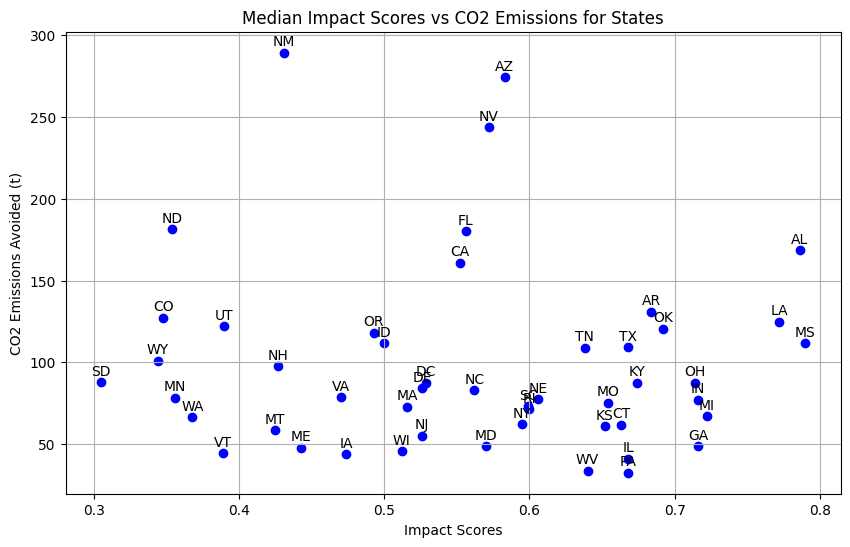

In [144]:
#Graph Impact Scores vs Median Emissions for State (because some states are overrepresented in the data)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(state_median['impact_score'], state_median['co2_avoided'], c='blue', marker='o')

# Set labels, title, and legend
plt.xlabel('Impact Scores')
plt.ylabel('CO2 Emissions Avoided (t)')
plt.title('Median Impact Scores vs CO2 Emissions for States')

# Annotate points with state names
for i, state in enumerate(state_median.index):
    plt.annotate(state, (state_median['impact_score'][i], state_median['co2_avoided'][i]),
                 textcoords="offset points", xytext=(0, 5), ha='center')

plt.grid(True)
plt.show()


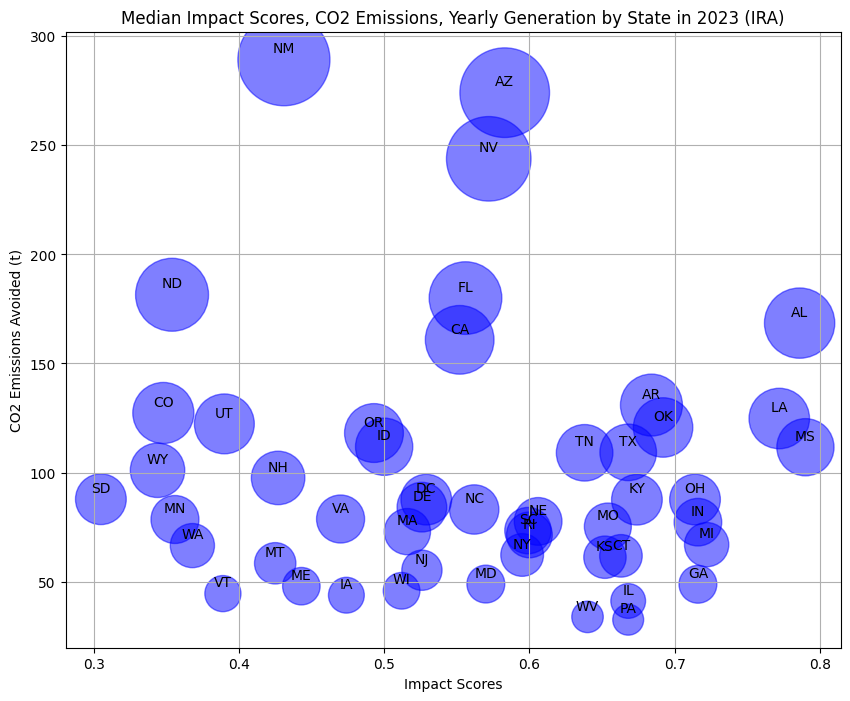

In [246]:
#Graph Buble CharT!!
# Create the bubble chart
plt.figure(figsize=(10, 8))
plt.scatter(state_median['impact_score'], state_median['co2_avoided'], s=[k/100 for k in state_median['yearly_kwh']], c='blue', alpha=0.5, label='States')

# Set labels, title, and legend
plt.xlabel('Impact Scores')
plt.ylabel('CO2 Emissions Avoided (t)')
plt.title('Median Impact Scores, CO2 Emissions, Yearly Generation by State in 2023 (IRA)')

# Annotate points with state names
for i, state in enumerate(state_median.index):
    plt.annotate(state, (state_median['impact_score'][i], state_median['co2_avoided'][i]),
                 textcoords="offset points", xytext=(0, 5), ha='center')

plt.grid(True)
plt.show()

In [97]:
#Calculate Job Creation

#Job multiplier per kw from NREL model
pv_job_mult = .0029 

#calculate for total 2023 Cap 1.8GW
total_jobs = 1.8 * 1000000 * pv_job_mult
print(total_jobs)

#Calculate per tract
benefits_data['jobs_created'] = benefits_data['kw']*pv_job_mult

print(benefits_data.head)

#Next: Compare with num_installers and med_solar_install

5220.0
<bound method NDFrame.head of         Unnamed: 0   index        GEOID    year  yearly_sunlight_kwh_median   
0             1369   16019   1073000100  2021.0                 12558.86040  \
1             1370   37456   1073000100  2022.0                 12558.86040   
2             1373   37457   1073000100  2023.0                 12558.86040   
3             1374  296213   1073000100  2023.0                 12558.86040   
4             1375  554969   1073000100  2023.0                 12558.86040   
...            ...     ...          ...     ...                         ...   
768854      813275  554522  56025000901  2032.0                 13753.51174   
768855      813276  813278  56025000901  2032.0                 13753.51174   
768856      813277  295767  56025000901  2033.0                 13753.51174   
768857      813278  554523  56025000901  2033.0                 13753.51174   
768858      813279  813279  56025000901  2033.0                 13753.51174   

        kw_med

In [252]:
print(cleaned_data['num_solar_installers'])

merged_cleaned_benefits = merged_mcda_benefits.merge(cleaned_data[['num_solar_installers']], left_on="GEOID", right_index=True)


GEOID
53067010600     16.0
53067011500      1.0
53067011300      3.0
53067011200      NaN
53067010920      3.0
               ...  
6071007408      38.0
6071007409     141.0
6071007410      67.0
6071007303      13.0
6071003404      39.0
Name: num_solar_installers, Length: 23400, dtype: float64


In [108]:
#Calculate benefits for year 2023
benefits_data_2023 = benefits_data[benefits_data['year'] == 2023]
print(benefits_data_2023.groupby(['scenario'])['kw'].sum()/1000000)
print(benefits_data_2023.groupby(['scenario'])['pm25_avoided'].sum())
print(benefits_data_2023.groupby(['scenario'])['co2_avoided'].sum())
print(benefits_data_2023.groupby(['scenario'])['jobs_created'].sum())

#Calculate cumulative benefits of Med scenario for year 2033
cum_cap = 41.3 #GW
cum_gen = 53740 #GWh
pm25_avoided_2033 = cum_gen * 1000000 * nat_avg_emission_rates['pm25'] * mt
co2_avoided_2033 = cum_gen * 1000000 * nat_avg_emission_rates['co2'] * mt
jobs_2033 = cum_cap * 1000000 * pv_job_mult
print(pm25_avoided_2033)
print(co2_avoided_2033)
print(jobs_2033)

scenario
bau     3.399206
high    3.493616
med     3.435518
Name: kw, dtype: float64
scenario
bau     180.528805
high    185.613983
med     182.484643
Name: pm25_avoided, dtype: float64
scenario
bau     2.910526e+06
high    2.992510e+06
med     2.942058e+06
Name: co2_avoided, dtype: float64
scenario
bau      9857.698102
high    10131.486616
med      9963.001377
Name: jobs_created, dtype: float64
2193.8430672
35369625.45008
119769.99999999999


In [94]:
#Top scores by state
# Group the data by states and calculate the sum of feasibility scores
state_jobs = benefits_data.loc[benefits_data['year'].isin([2021, 2022, 2023, 2024, 2025])].groupby(['state_abbr', 'scenario'])['jobs_created'].sum()

# Get the top 10 states with the highest median feasibility scores
print(state_jobs.nlargest(30))

state_abbr  scenario
CA          high        476.243192
            med         467.084669
            bau         457.926146
FL          high        100.730593
            med          98.793466
            bau          96.856339
AZ          high         95.805265
            med          93.962856
            bau          92.120447
CO          high         67.661327
            med          66.360147
            bau          65.058968
NV          high         56.022498
            med          54.945143
TX          high         54.588760
NV          bau          53.867787
TX          med          53.538976
            bau          52.489192
NJ          high         52.387936
            med          51.380476
            bau          50.373016
MA          high         36.574945
            med          35.871581
            bau          35.168217
DC          high         25.079931
LA          high         24.635820
DC          med          24.597625
CT          high         24.309339

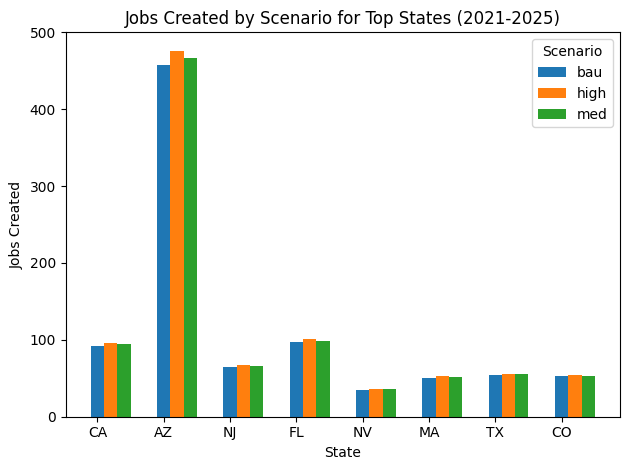

In [93]:
#Map job creation

# List of selected states
selected_states = ['CA', 'AZ', 'NJ', 'FL', 'NV', 'MA', 'TX', 'CO']

# Filter the data for selected states and years 2023 and 2024
selected_states_data = benefits_data[(benefits_data['state_abbr'].isin(selected_states)) &
                                     (benefits_data['year'].isin([2021, 2022, 2023, 2024, 2025]))]

# Create a figure and axis for the plot
# plt.figure(figsize=(10, 6))
ax = plt.gca()

# Group the data by 'state_abbr' and 'scenario' and calculate the sum of 'jobs_created' for each group
grouped_data = selected_states_data.groupby(['state_abbr', 'scenario'])['jobs_created'].sum().unstack()

# Get the number of scenarios for positioning the bars
num_scenarios = len(grouped_data.columns)

# Get the width for each bar
bar_width = 0.2

# Calculate the positions of the bars for each state
positions = [i + bar_width/2 for i in range(len(selected_states))]

# Plot the bars for each scenario
for i, scenario in enumerate(grouped_data.columns):
    ax.bar([pos + i*bar_width for pos in positions], grouped_data[scenario], width=bar_width, label=scenario)

# Customize the plot
plt.xlabel('State')
plt.ylabel('Jobs Created')
plt.title('Jobs Created by Scenario for Top States (2021-2025)')
plt.xticks(positions, selected_states)
plt.legend(title='Scenario')

# Show the plot
plt.tight_layout()
plt.show()

In [255]:
#Jobs created by state
#Graph Impact Scores vs Median Emissions for State (because some states are overrepresented in the data)
total_jobs = benefits_data[(benefits_data['year'] == 2023) & (benefits_data['scenario'] == 'med')].groupby(['year', 'state_abbr'])['jobs_created'].sum()
installers_sum = merged_cleaned_benefits.groupby('state_abbr')['num_solar_installers'].sum()
# total_jobs = total_jobs.groupby('state_abbr').cumsum()
# print(total_jobs[total_jobs['year' == 2033]])
# print(total_jobs)
print(installers_sum)


state_abbr
AL         0.0
AR         0.0
AZ     16474.0
CA    179022.0
CO      8754.0
CT      6975.0
DC      1969.0
DE         0.0
FL      7395.0
GA         0.0
IA         0.0
ID         0.0
IL       877.0
IN       109.0
KS        86.0
KY        33.0
LA         0.0
MA     16445.0
MD      2130.0
ME         0.0
MI         1.0
MN       237.0
MO       515.0
MS         0.0
MT        76.0
NC      1535.0
ND         0.0
NE         0.0
NH       238.0
NJ     23412.0
NM      3047.0
NV     10371.0
NY     11569.0
OH       162.0
OK        42.0
OR      2592.0
PA       413.0
RI      1632.0
SC      1112.0
SD         0.0
TN         0.0
TX       166.0
UT      2021.0
VA      1409.0
VT       206.0
WA      1595.0
WI       381.0
WV         0.0
WY         0.0
Name: num_solar_installers, dtype: float64


year    state_abbr
2023.0  AL             191.143960
        AR              46.013652
        AZ             508.264230
        CA            2031.378020
        CO             206.870354
        CT              62.526782
        DC              43.261719
        DE              29.979548
        FL            1056.684262
        GA              92.419215
        IA              38.154746
        ID              16.648055
        IL             238.056380
        IN             225.868886
        KS              47.665400
        KY              96.185082
        LA             136.712898
        MA             171.714545
        MD              89.497605
        ME               7.447007
        MI             338.463151
        MN             148.693827
        MO             142.297260
        MS              39.896364
        MT               7.775811
        NC             168.965030
        ND              21.906568
        NE              46.903508
        NH              21.37

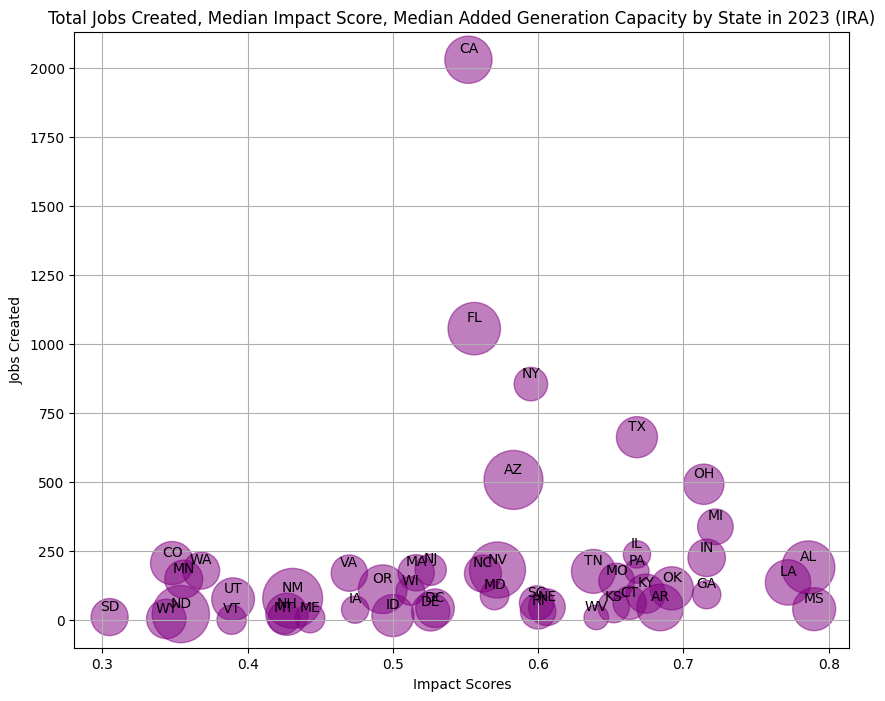

In [283]:
#Graph Bubble Chart Impact Scores vs Jobs Created (because some states are overrepresented in the data)
total_jobs_count = benefits_data[(benefits_data['year'] == 2023) & (benefits_data['scenario'] == 'med')].groupby(['year', 'state_abbr'])['jobs_created'].count()
total_jobs_sum = benefits_data[(benefits_data['year'] == 2023) & (benefits_data['scenario'] == 'med')].groupby(['year', 'state_abbr'])['jobs_created'].sum()
print(total_jobs)
print(state_median['kw'])
#Graph Buble CharT!!
# Create the bubble chart
plt.figure(figsize=(10, 8))
plt.scatter(state_median['impact_score'], total_jobs_sum.values, s=[k * 7 for k in state_median['kw']], c='purple', alpha=0.5, label='States')

# Set labels, title, and legend
plt.xlabel('Impact Scores')
plt.ylabel('Jobs Created')
plt.title('Total Jobs Created, Median Impact Score, Median Added Generation Capacity by State in 2023 (IRA)')

# Annotate points with state names
for i, state in enumerate(state_median.index):
    plt.annotate(state, (state_median['impact_score'][i], total_jobs_sum.values[i]),
                 textcoords="offset points", xytext=(0, 5), ha='center')

plt.grid(True)
plt.show()

            jobs_created  num_solar_installers
state_abbr                                    
AZ            508.264230               16474.0
CO            206.870354                8754.0
CT             62.526782                6975.0
DC             43.261719                1969.0
FL           1056.684262                7395.0
IL            238.056380                 877.0
IN            225.868886                 109.0
KS             47.665400                  86.0
KY             96.185082                  33.0
MA            171.714545               16445.0
MD             89.497605                2130.0
MI            338.463151                   1.0
MN            148.693827                 237.0
MO            142.297260                 515.0
MT              7.775811                  76.0
NC            168.965030                1535.0
NH             21.376718                 238.0
NJ            182.810048               23412.0
NM             79.236524                3047.0
NV           

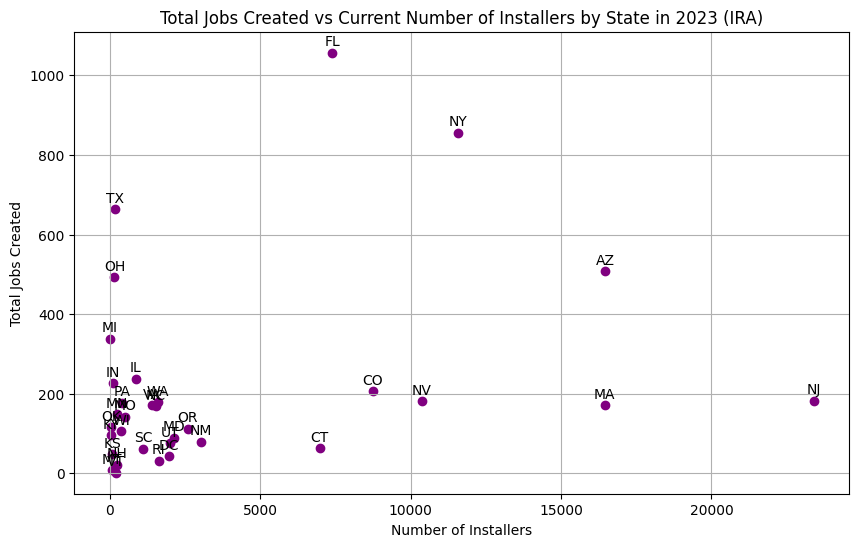

In [280]:
#Graph Impact Scores vs Median Emissions for State (because some states are overrepresented in the data)
#vs unemployment, would be interesting
installers_sum = merged_cleaned_benefits.groupby('state_abbr')[['jobs_created','num_solar_installers']].sum().reset_index()
installers_sum = installers_sum[(installers_sum['state_abbr'] != 'CA') & (installers_sum['num_solar_installers'] != 0)].set_index('state_abbr')
# total_jobs_sum = total_jobs_sum[(total_jobs_sum['state_abbr'] != 'CA')]
print(installers_sum)
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(installers_sum['num_solar_installers'], installers_sum['jobs_created'], c='purple', marker='o')

# Set labels, title, and legend
plt.xlabel('Number of Installers')
plt.ylabel('Total Jobs Created')
plt.title('Total Jobs Created vs Current Number of Installers by State in 2023 (IRA)')

# Annotate points with state names
for i, state in enumerate(installers_sum.index):
    plt.annotate(state, (installers_sum['num_solar_installers'][i], installers_sum['jobs_created'][i]),
                 textcoords="offset points", xytext=(0, 5), ha='center')

plt.grid(True)
plt.show()

In [184]:
#Energy burden calculation

#Avg cost of panels from NREL report
install_cost_dlkw = 3000
lic_itc = 0.4
avg_install_size = 6

energy_burden_data = cleaned_data[['yearly_sunlight_kwh_median', 'kw_median', 'avg_monthly_consumption_kwh', 'dlrs_kwh', 'median_income', 'energy_burden', 'state_abbr']].copy()
# print(energy_burden_data.head)

#yearly cost = ((monthly consumption x 12) - new capacity) x cost

#first calculate the #of hours per year for the area to get the capacity factor
energy_burden_data['pv_cap_factor'] = energy_burden_data['yearly_sunlight_kwh_median']/energy_burden_data['kw_median']

#Make intermediate calculations
energy_burden_data['yearly_generation'] = energy_burden_data['pv_cap_factor'] * avg_install_size
energy_burden_data['yearly_energy_cost'] = ((energy_burden_data['avg_monthly_consumption_kwh']*12) - energy_burden_data['yearly_generation']) * energy_burden_data['dlrs_kwh']
energy_burden_data['avg_pvinstall_cost_itc'] = avg_install_size*install_cost_dlkw *(1-0.4)

#calculate energy burden for different scenarios
energy_burden_data['energy_burden_high'] = (energy_burden_data['yearly_energy_cost']/energy_burden_data['median_income']) * 100
energy_burden_data['energy_burden_med'] = ((energy_burden_data['yearly_energy_cost'] + energy_burden_data['avg_pvinstall_cost_itc'])/energy_burden_data['median_income']) * 100

#change in energy burden = new energy burden - old energy burden / old energy burden
energy_burden_data['energy_burden_chg'] = ((energy_burden_data['energy_burden_high'] - energy_burden_data['energy_burden']) / energy_burden_data['energy_burden']) * 100
energy_burden_data['energy_burden_chg_med'] = ((energy_burden_data['energy_burden_med'] - energy_burden_data['energy_burden']) / energy_burden_data['energy_burden']) * 100

#Given you get an array that can handle your consumption, and you get the ITC how many years would it take to pay off the panels if the energy burden was kept the same?

#calculate the equivalent capacity needed to cover yearly consumption
energy_burden_data['equal_pvinstall'] = (energy_burden_data['avg_monthly_consumption_kwh']*12)/energy_burden_data['pv_cap_factor']

#calculate the cost of installations
energy_burden_data['equal_pvinstall_cost'] = energy_burden_data['equal_pvinstall']*install_cost_dlkw
energy_burden_data['equal_pvinstall_cost_itc'] = energy_burden_data['equal_pvinstall']*install_cost_dlkw *(1-0.4)

#calculate the number of years it would take to pay off the cost of the installation if the energy burden were kept the same
energy_burden_data['payoff_years_bau'] = energy_burden_data['equal_pvinstall_cost'] / ((energy_burden_data['energy_burden']/100)*energy_burden_data['median_income'])
energy_burden_data['payoff_years'] = energy_burden_data['equal_pvinstall_cost_itc'] / ((energy_burden_data['energy_burden']/100)*energy_burden_data['median_income'])



print(energy_burden_data.head)

<bound method NDFrame.head of              yearly_sunlight_kwh_median  kw_median   
GEOID                                                
53067010600                 8204.921338       9.00  \
53067011500                13135.612170      14.50   
53067011300                12302.533000      13.00   
53067011200                12692.213070      13.50   
53067010920                11110.893700      12.00   
...                                 ...        ...   
6071007408                 16562.247300      10.25   
6071007409                 13348.937480       8.25   
6071007410                 18315.401560      11.25   
6071007303                 13068.990100       8.75   
6071003404                 14607.244600       9.25   

             avg_monthly_consumption_kwh  dlrs_kwh  median_income   
GEOID                                                               
53067010600                   867.008585   0.11116        26769.0  \
53067011500                   867.008585   0.11116        30

count    23372.000000
mean       -80.364496
std         68.275722
min      -1325.397501
25%       -101.906690
50%        -73.223689
75%        -38.432038
max       1427.746539
Name: energy_burden_chg, dtype: float64


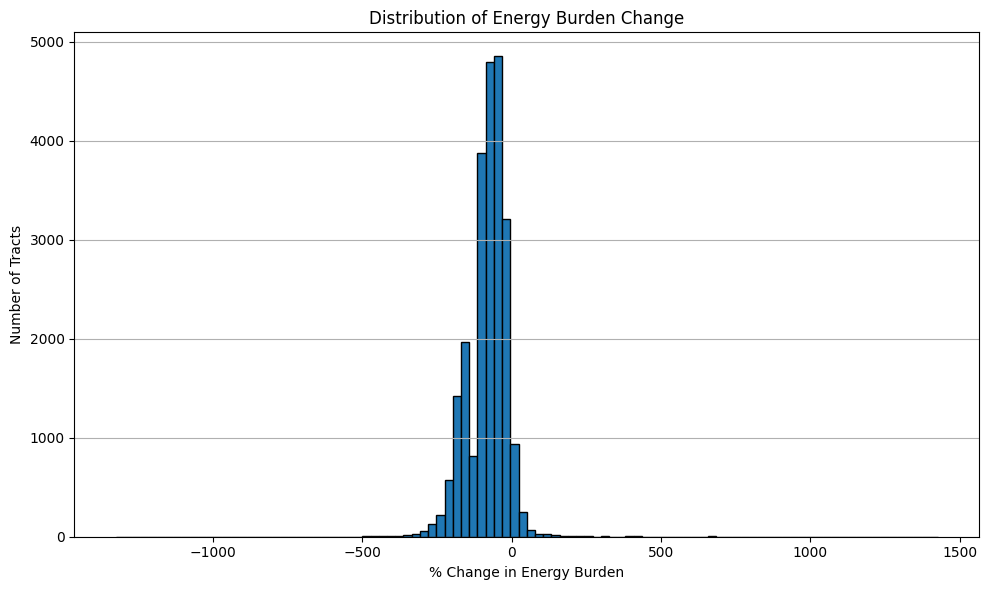

In [158]:
# Create histogram for Change in Energy Burden

#get summary statistics
print(energy_burden_data['energy_burden_chg'].describe())

plt.figure(figsize=(10, 6))
plt.hist(energy_burden_data['energy_burden_chg'], bins=100, edgecolor='black')

# Customize the plot
plt.xlabel('% Change in Energy Burden')
plt.ylabel('Number of Tracts')
plt.title('Distribution of Energy Burden Change')
plt.grid(axis='y')  # Optional: Show gridlines on the y-axis

plt.tight_layout()
plt.show()

count    23372.000000
mean      1348.334426
std        949.009618
min         52.898563
25%        921.696201
50%       1174.668585
75%       1532.315761
max      31155.244474
Name: energy_burden_chg_med, dtype: float64


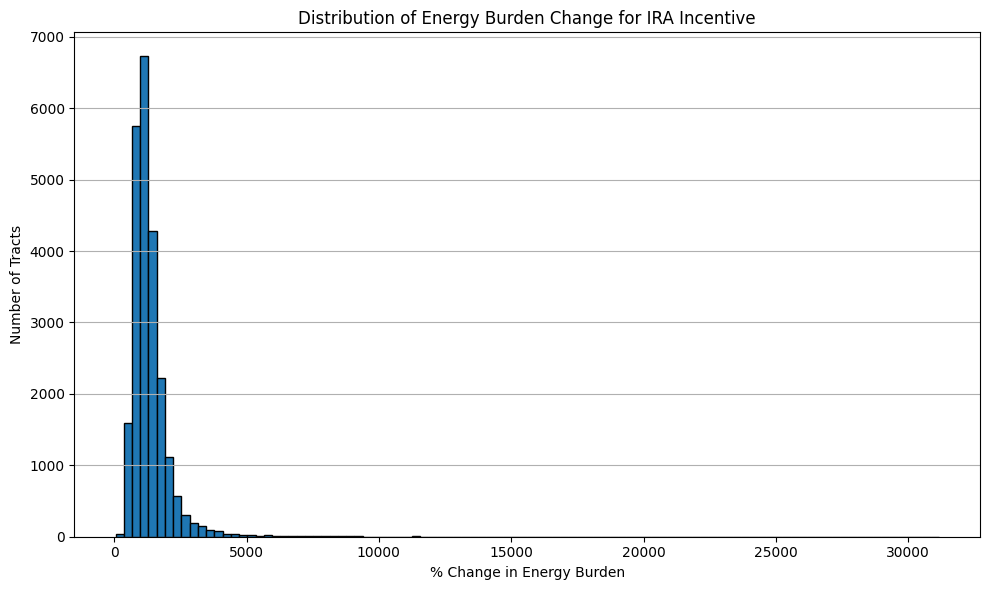

In [182]:
# Create histogram for Change in Energy Burden for Med

#get summary statistics
print(energy_burden_data['energy_burden_chg_med'].describe())

plt.figure(figsize=(10, 6))
plt.hist(energy_burden_data['energy_burden_chg_med'], bins=100, edgecolor='black')

# Customize the plot
plt.xlabel('% Change in Energy Burden')
plt.ylabel('Number of Tracts')
plt.title('Distribution of Energy Burden Change for IRA Incentive')
plt.grid(axis='y')  # Optional: Show gridlines on the y-axis

plt.tight_layout()
plt.show()

count    23372.000000
mean        17.875958
std         12.454975
min          2.710810
25%         11.696774
50%         15.868838
75%         21.192301
max        494.890590
Name: payoff_years, dtype: float64
count    23400.000000
mean         7.796482
std          2.589372
min          2.840212
25%          5.902192
50%          7.601043
75%         10.098641
max         21.664611
Name: equal_pvinstall, dtype: float64


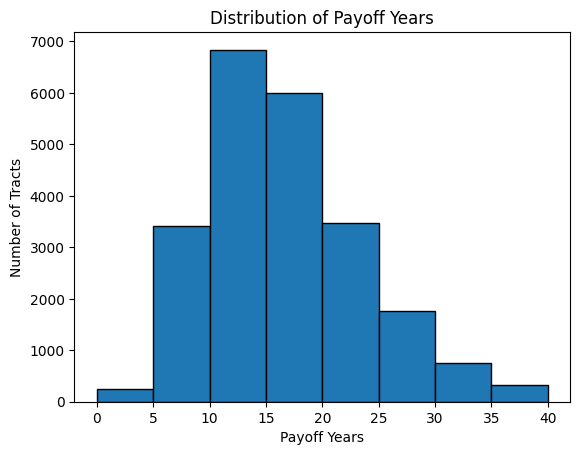

In [159]:
# Create histogram for Payoff Years

#get summary statistics
print(energy_burden_data['payoff_years'].describe())

#calculate the equivalent capacity needed to cover yearly consumption
print(energy_burden_data['equal_pvinstall'].describe())

threshold_min = 0  # Minimum acceptable value for 'payoff_years'
threshold_max = 40  # Maximum acceptable value for 'payoff_years'

# Filter the data to remove extreme values
filtered_data = energy_burden_data[(energy_burden_data['payoff_years'] >= threshold_min) & (energy_burden_data['payoff_years'] <= threshold_max)]

bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
# Create the histogram using the filtered data
plt.hist(filtered_data['payoff_years'], bins=bins, edgecolor='black')

# Customize the plot
plt.xlabel('Payoff Years')
plt.ylabel('Number of Tracts')
plt.title('Distribution of Payoff Years')
# plt.grid(axis='y')  # Optional: Show gridlines on the y-axis

# plt.tight_layout()
plt.show()

count    23372.000000
mean        29.793264
std         20.758292
min          4.518017
25%         19.494624
50%         26.448064
75%         35.320502
max        824.817649
Name: payoff_years_bau, dtype: float64


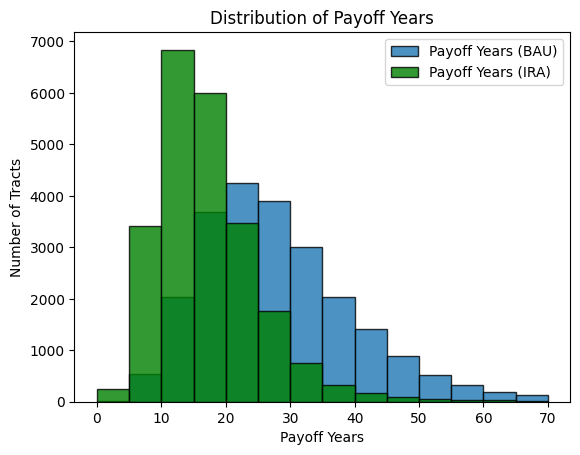

In [282]:
import matplotlib.pyplot as plt

#get summary statistics
print(energy_burden_data['payoff_years_bau'].describe())

bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
# Create the histogram using the filtered data
plt.hist(energy_burden_data['payoff_years_bau'], bins=bins, edgecolor='black', alpha=0.8, label='Payoff Years (BAU)')
plt.hist(energy_burden_data['payoff_years'], bins=bins, color='green', edgecolor='black', alpha=0.8, label='Payoff Years (IRA)')
# Add the 'payoff_years_bau' histogram using the same bins and a different color

# Customize the plot
plt.xlabel('Payoff Years')
plt.ylabel('Number of Tracts')
plt.title('Distribution of Payoff Years')
plt.legend()  # Show the legend with labels for each data series

plt.show()


In [177]:
state_median_energy = energy_burden_data.groupby('state_abbr')[['energy_burden_chg']].median().abs()
print(state_median_energy)

            energy_burden_chg
state_abbr                   
AL                  25.056814
AR                  37.346226
AZ                  60.891346
CA                 174.185086
CO                 117.204768
CT                  81.104260
DC                  83.952699
DE                  46.247660
FL                  27.828855
GA                  40.376377
IA                  57.223757
ID                  51.978479
IL                  93.195635
IN                  46.119323
KS                  66.335132
KY                  38.822484
LA                  40.253988
MA                  98.030399
MD                  44.137846
ME                 105.767477
MI                  77.488235
MN                  80.281682
MO                  56.434750
MS                  32.665639
MT                  76.700213
NC                  18.214481
ND                  44.849405
NE                  68.510554
NH                  93.462715
NJ                  95.647912
NM                 155.924107
NV        

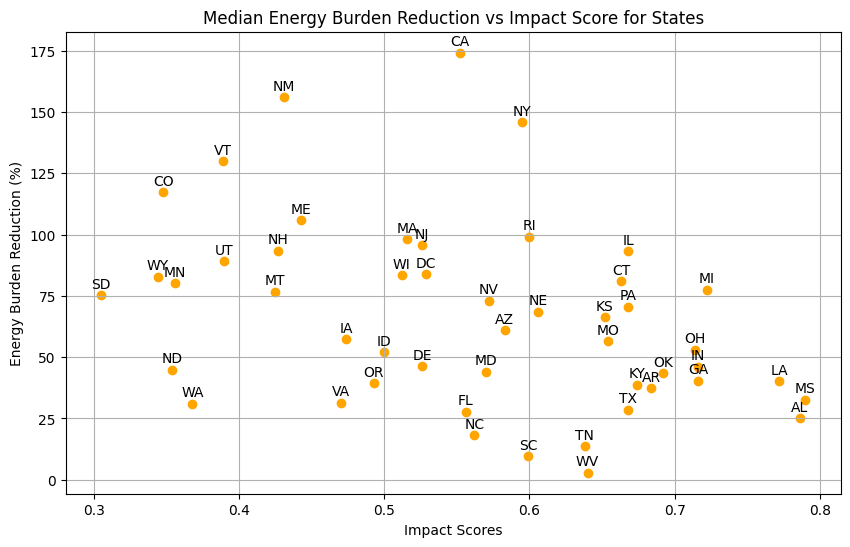

In [179]:
#Graph Impact Scores vs Median Emissions for State (because some states are overrepresented in the data)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(state_median['impact_score'], state_median_energy.values, c='orange', marker='o')

# Set labels, title, and legend
plt.xlabel('Impact Scores')
plt.ylabel('Energy Burden Reduction (%)')
plt.title('Median Energy Burden Reduction vs Impact Score for States')

# Annotate points with state names
for i, state in enumerate(state_median.index):
    plt.annotate(state, (state_median['impact_score'][i], state_median_energy.values[i]),
                 textcoords="offset points", xytext=(0, 5), ha='center')

plt.grid(True)
plt.show()

In [160]:
# #load state boundaries file
state_geodata = gpd.read_file("data/tl_2010_us_state10.shx")

print(state_geodata)

#Merge with state-level dataset


#write to file


                                             geometry
0   POLYGON ((-108.62131 45.00028, -108.61973 45.0...
1   POLYGON ((-80.51909 39.96220, -80.51910 39.962...
2   POLYGON ((-84.05271 38.77123, -84.05377 38.771...
3   POLYGON ((-109.04616 34.57929, -109.04616 34.5...
4   POLYGON ((-75.74776 39.14334, -75.74765 39.141...
5   MULTIPOLYGON (((-71.65321 41.21780, -71.64938 ...
6   POLYGON ((-124.55228 42.95452, -124.54517 42.9...
7   MULTIPOLYGON (((-67.41804 18.37300, -67.41992 ...
8   POLYGON ((-88.77649 42.49191, -88.77650 42.492...
9   POLYGON ((-102.93878 48.99933, -102.91772 48.9...
10  POLYGON ((-117.16600 36.97111, -117.16900 36.9...
11  POLYGON ((-84.12944 34.98754, -84.12923 34.987...
12  MULTIPOLYGON (((-74.03940 40.70047, -74.03833 ...
13  POLYGON ((-94.55218 36.10224, -94.55219 36.102...
14  POLYGON ((-99.54112 36.99961, -99.54157 36.999...
15  POLYGON ((-102.08255 42.99936, -102.08253 42.9...
16  POLYGON ((-114.04713 39.90604, -114.04713 39.9...
17  MULTIPOLYGON (((177.4459

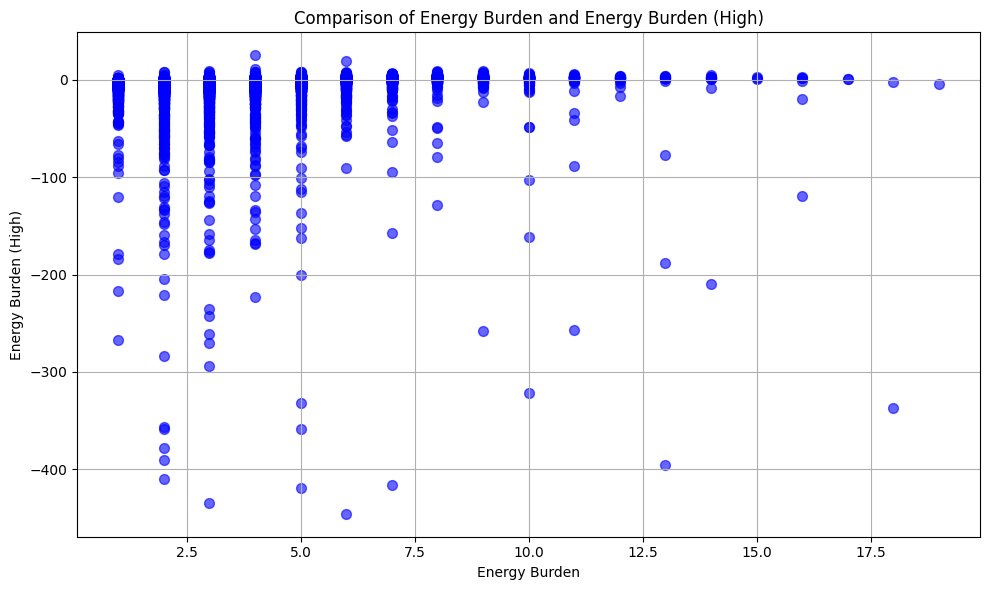

In [52]:
#Visualize energy burden change

plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size

plt.scatter(energy_burden_data['energy_burden'], energy_burden_data['energy_burden_high'], s=50, alpha=0.6, color='b')

plt.xlabel('Energy Burden')
plt.ylabel('Energy Burden (High)')
plt.title('Comparison of Energy Burden and Energy Burden (High)')
plt.grid(True)  # Optional: Show gridlines
plt.tight_layout()

plt.show()